In [1]:
#!/usr/bin/env python
import numpy as np
import random
from tqdm import tqdm
import pickle

np.set_printoptions(precision=4, suppress=True)

# ------------------------------
# Q-Learning Code Implementation
# ------------------------------
class GridworldEnv:
    def __init__(self, grid_size=(4, 4)):
        self.rows, self.cols = grid_size
        # Define special states with forced destination and reward.
        self.special_states = {
            (0, 1): {'dest': (3, 1), 'reward': 10},
            (0, 3): {'dest': (2, 3), 'reward': 5}
        }
        # Actions: 0: left, 1: up, 2: right, 3: down.
        self.actions = {
            0: (0, -1),
            1: (-1, 0),
            2: (0, 1),
            3: (1, 0)
        }
        self.action_list = [0, 1, 2, 3]
        self.intended_prob = 0.9
        self.slip_prob = 0.05  # probability for each perpendicular move

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols

    def get_perpendicular_actions(self, action):
        if action in [0, 2]:
            return [1, 3]
        elif action in [1, 3]:
            return [0, 2]
        else:
            return []

    def get_outcomes(self, state, action):
        """
        Computes all possible outcomes for a given state and action.
        Returns a list of tuples: (probability, next_state, reward)
        following the dynamics of the gridworld.
        """
        if state in self.special_states:
            forced_dest = self.special_states[state]['dest']
            reward = self.special_states[state]['reward']
            return [(1.0, forced_dest, reward)]

        outcomes = []
        intended_action = action
        base_reward = 0
        probs = [self.intended_prob, self.slip_prob, self.slip_prob]
        actions_to_consider = [intended_action] + self.get_perpendicular_actions(intended_action)
        for act, p in zip(actions_to_consider, probs):
            dr, dc = self.actions[act]
            next_state = (state[0] + dr, state[1] + dc)
            if not self.in_bounds(next_state):
                outcomes.append((p, state, -1))
            else:
                outcomes.append((p, next_state, base_reward))
        return outcomes

def compute_optimal_Q(env, gamma=0.9, tol=1e-9, max_iter=10000):
    """
    Compute the optimal Q-function Q* using value iteration.
    Returns Q* as a (rows x cols x num_actions) numpy array.
    """
    Q = np.zeros((env.rows, env.cols, len(env.action_list)))
    for it in range(max_iter):
        Q_new = np.zeros_like(Q)
        for r in range(env.rows):
            for c in range(env.cols):
                state = (r, c)
                for a in env.action_list:
                    if state in env.special_states:
                        forced_dest = env.special_states[state]['dest']
                        reward = env.special_states[state]['reward']
                        Q_new[r, c, a] = reward + gamma * np.max(Q[forced_dest[0], forced_dest[1]])
                    else:
                        probs = [env.intended_prob, env.slip_prob, env.slip_prob]
                        actions_to_consider = [a] + env.get_perpendicular_actions(a)
                        value = 0.0
                        for p, act in zip(probs, actions_to_consider):
                            dr, dc = env.actions[act]
                            next_state = (r + dr, c + dc)
                            if not env.in_bounds(next_state):
                                value += p * (-1 + gamma * np.max(Q[r, c]))
                            else:
                                value += p * (0 + gamma * np.max(Q[next_state[0], next_state[1]]))
                        Q_new[r, c, a] = value
        err = np.max(np.abs(Q_new - Q))
        Q = Q_new
        if err < tol:
            print(f"Value iteration converged in {it+1} iterations with error {err:.2e}.")
            break
    return Q

class QLearningAgent:
    def __init__(self, env, alpha_constant=0.1,alpha_diminishing=0.5, gamma=0.9):
        self.env = env
        self.alpha_constant = alpha_constant      # learning rate
        self.alpha_diminishing = alpha_diminishing 
        self.gamma = gamma      # discount factor
        #self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros((env.rows, env.cols, len(env.action_list)))

from collections import deque

def run_q_learning_LD2Z(Q_star, steps=2, gamma=0.7, eta=0.65):
    env = GridworldEnv()
    agent = QLearningAgent(env, gamma=gamma)

    Q_traj = agent.Q.copy()
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    error_history = []
    partial_sum = np.zeros_like(Q_star)
    max_norm = 0.0

    # --- tail buffer for last sqrt(n) iterates ---
    tail_len = int(np.sqrt(steps))
    tail_buf = deque(maxlen=tail_len)

    for t in tqdm(range(steps), desc="Linearly decaying steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    lr = eta * (1 - t/steps)
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op

        Q_traj = agent.Q.copy()
        tail_buf.append(Q_traj)  # store last sqrt(n) Qs

        error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_sum += (Q_traj - Q_star)
        current_norm = np.max(np.abs(partial_sum))
        if current_norm > max_norm:
            max_norm = current_norm

    # Tail-average Q over the last sqrt(n) iterates
    Q_bar_tail = np.mean(np.stack(list(tail_buf), axis=0), axis=0)  # same shape as Q_traj

    # Return Q_bar_tail as an extra
    return Q_bar_tail


In [2]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib


def run_single_q_learning_LD2Z(seed, Q_star, steps, gamma, eta):
    np.random.seed(seed)
    random.seed(seed)
    Q_bar_tail = run_q_learning_LD2Z(
        Q_star=Q_star, steps=steps, gamma=gamma, eta=eta
    )
    # Return the tail-average too
    return  Q_bar_tail


def run_experiments_parallel(B, Q_star,
                             gamma, eta, steps, n_jobs=5):
    seeds = list(range(B))
    with tqdm_joblib(tqdm(total=B, desc="Running experiments with linearly decaying step-sizes", ncols=100)):
        results_LD2Z = Parallel(n_jobs=n_jobs)(
            delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta)
            for seed in seeds
        )
    return results_LD2Z



/Users/sohambonnerjee/anaconda3/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
if __name__ == "__main__":
    # Experiment parameters.
    B = 1000
    steps= 10000
    gamma = 0.1
    eta=0.05
    ###### Compute Q^star

    env = GridworldEnv()
    agent = QLearningAgent(env, gamma=gamma)
    Q_star = compute_optimal_Q(env, gamma=gamma)

    results_ld2z = run_experiments_parallel(B, Q_star, gamma, eta, steps, n_jobs=6)

    # Save exactly as a list of (4,4,4) arrays, one per run
    with open(f"tail_Qbar_list_ld2z_{steps}.pkl", "wb") as f:
        pickle.dump(results_ld2z, f)
    print(f"Saved tail_Qbar_list_ld2z_{steps}.pkl with {len(results_ld2z)} runs.")



Value iteration converged in 11 iterations with error 5.37e-10.


Running experiments with linearly decaying step-sizes:   0%|               | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Linearly decaying steps:  98%|██████████████████████████████▎| 9786/10000 [00:04<00:00, 2697.60it/s]

Saved tail_Qbar_list_ld2z.pkl with 1000 runs.


Linearly decaying steps: 100%|██████████████████████████████| 10000/10000 [00:04<00:00, 2268.58it/s]


Running experiments with linearly decaying step-sizes:   0%|               | 0/1000 [14:43<?, ?it/s]


Value iteration converged in 11 iterations with error 5.37e-10.
B=1000, d=64


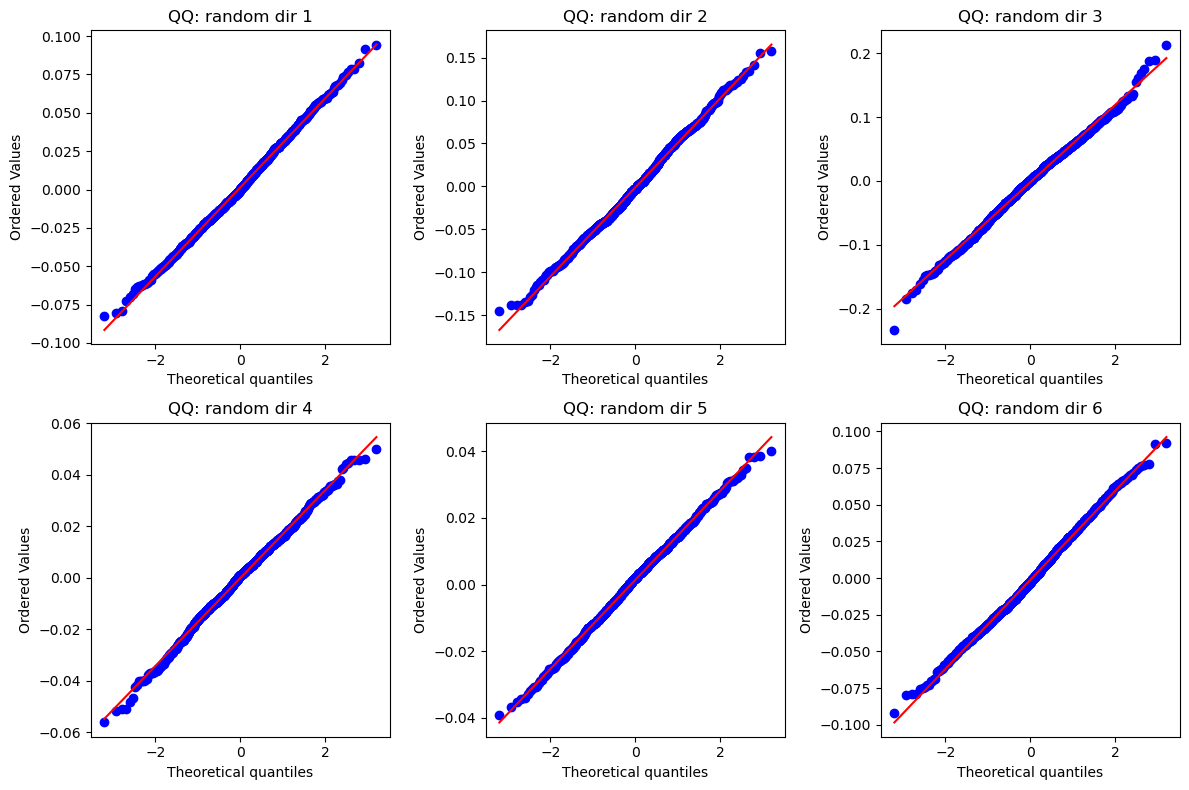

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# If available, SciPy helps with QQ-plots and chi^2 quantiles:
from scipy import stats as st
from numpy.linalg import eigh


env = GridworldEnv()
Q_star = compute_optimal_Q(env, gamma=gamma)

def vec(q): 
    return np.asarray(q).reshape(-1)

Q_star_vec = vec(Q_star)                                  # (64,)



Qbars = np.stack([vec(Qbar) for Qbar in tail_Qbar_list_ld2z], axis=0)  # (B, 64)

# Build Z (now shapes match)
n = steps
Z = (n**0.25) * (Qbars - Q_star_vec)                      # (B, 64)

B, d = Z.shape
print(f"B={B}, d={d}")

# --- Estimate mean/covariance and whiten ---
# mu_hat = Z.mean(axis=0)
# Sigma_hat = np.cov(Z, rowvar=False, bias=False)
# # small ridge to avoid numerical issues
# eps = 1e-10 * np.trace(Sigma_hat) / d
# eigvals, eigvecs = eigh(Sigma_hat + eps * np.eye(d))
# Sigma_half_inv = eigvecs @ np.diag(1.0 / np.sqrt(np.maximum(eigvals, 1e-18))) @ eigvecs.T
W = Z       # whitened data ~ approx N(0, I_d)

# --- (A) Componentwise QQ-plots for first few dims ---
# num_dims_to_plot = min(8, d)
# plt.figure(figsize=(12, 8))
# for j in range(num_dims_to_plot):
#     plt.subplot(2, (num_dims_to_plot+1)//2, j+1)
#     st.probplot(W[:, j], dist="norm", plot=plt)
#     plt.title(f"QQ: component {j}")
# plt.tight_layout(); plt.show()

# --- (B) Random-direction QQ-plots ---
rng = np.random.default_rng(123)
num_dirs = 6
plt.figure(figsize=(12, 8))
for k in range(num_dirs):
    u = rng.normal(size=d); u /= np.linalg.norm(u)
    proj = W @ u
    plt.subplot(2, 3, k+1)
    st.probplot(proj, dist="norm", plot=plt)
    plt.title(f"QQ: random dir {k+1}")
plt.tight_layout(); plt.show()



Value iteration converged in 11 iterations with error 5.37e-10.
B=1000, d=64


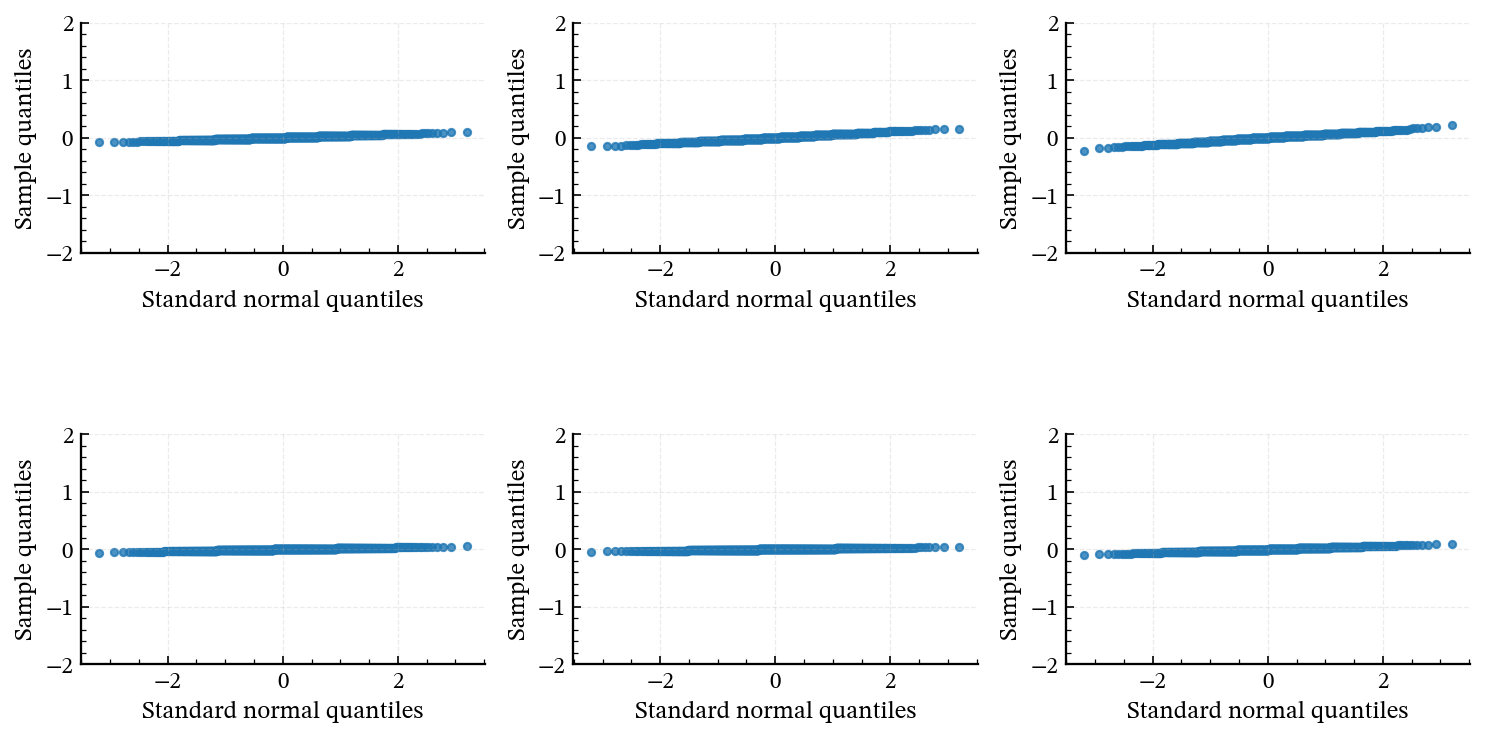

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import stats as st
from numpy.linalg import eigh

# -----------------------------
# Minimal, modern, journal vibe
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times New Roman", "DejaVu Serif", "STIXGeneral", "CMU Serif"],
    "mathtext.fontset": "stix",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1.1,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.autolayout": False,
})


def vec(q):
    return np.asarray(q).reshape(-1)

# Environment bits may be defined elsewhere; fall back gracefully.
try:
    env = GridworldEnv()
    Q_star = compute_optimal_Q(env, gamma=gamma)
except NameError:
    env = None
    Q_star = tail_Qbar_list_ld2z[0]  # fallback: compare to first sample
    # (If you prefer to enforce Q*, raise instead.)

Q_star_vec = vec(Q_star)  # (d,)

# --- Load tail-average Qbars and Q* ---
with open(f"tail_Qbar_list_ld2z_{steps}.pkl", "rb") as f:
    tail_Qbar_list_ld2z = pickle.load(f)

Qbars = np.stack([vec(Qbar) for Qbar in tail_Qbar_list_ld2z], axis=0)  # (B, d)

# Step count for scaling; if undefined, default to len of trajectory if known or 1.
try:
    n = steps
except NameError:
    n = 1

Z = (n ** 0.25) * (Qbars - Q_star_vec)  # (B, d)
B, d = Z.shape
print(f"B={B}, d={d}")

# --- (optional) estimate whitening; keep identity unless uncommented ---
# Sigma_hat = np.cov(Z, rowvar=False, bias=False)
# eps = 1e-10 * np.trace(Sigma_hat) / d
# evals, evecs = eigh(Sigma_hat + eps * np.eye(d))
# Sigma_half_inv = evecs @ np.diag(1.0 / np.sqrt(np.maximum(evals, 1e-18))) @ evecs.T
# W = (Z - Z.mean(axis=0)) @ Sigma_half_inv
W = Z  # unwhitened by default (as in your snippet)


# Random-direction QQ-plots as pure scatter vs. standard normal quantiles
rng = np.random.default_rng(123)
num_dirs = 6
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()
for k in range(num_dirs):
    # random unit direction
    u = rng.normal(size=d)
    u /= np.linalg.norm(u)
    proj = W @ u

    # get theoretical and sample quantiles
    (osm, osr), _ = st.probplot(proj, dist="norm")

    ax = axes[k]
    ax.scatter(osm, osr, s=12, alpha=0.8)
    ax.set_title("")
    ax.set_xlabel("Standard normal quantiles")
    ax.set_ylabel("Sample quantiles")
    ax.minorticks_on()
    
    # 🔑 Make x and y scales the same
    ax.set_aspect("equal", adjustable="box")
    ax.set_ylim(-2, 2)


# hide unused axes if any
for ax in axes[num_dirs:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()



# -----------------------------------------
# (Optional) Save — commented out by design
# -----------------------------------------
fig.savefig(f"qq_random_dirs_ld2z_{steps}.png", bbox_inches="tight")
# fig.savefig("qq_random_dirs_ld2z.pdf", bbox_inches="tight")

# ---------------------------------------------------------
# (A) Componentwise QQ-plots for the first few coordinates
# ---------------------------------------------------------
# num_dims_to_plot = min(8, d)
# rows = 2
# cols = (num_dims_to_plot + 1) // 2
# fig2, axes2 = plt.subplots(rows, cols, figsize=(10.5, 6.2), constrained_layout=False)
# axes2 = np.atleast_1d(axes2).ravel()
# for j in range(num_dims_to_plot):
#     ax = axes2[j]
#     (osm, osr), (slope, intercept, r) = st.probplot(W[:, j], dist="norm", plot=ax)
#     ax.set_title(rf"QQ — component {j+1}")
#     ax.set_xlabel("Theoretical quantiles")
#     ax.set_ylabel("Sample quantiles")
#     ax.minorticks_on()
# for ax in axes2[num_dims_to_plot:]:
#     ax.set_visible(False)
# plt.tight_layout()
# plt.show()
#
# # Save (commented)
# # fig2.savefig("qq_components_ld2z.png", bbox_inches="tight")
# # fig2.savefig("qq_components_ld2z.pdf", bbox_inches="tight")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from scipy import stats as st

# Z: shape (B, d), already computed as n**0.25 * (Qbar - Q_star_vec)
B, d = Z.shape
idx = np.random.default_rng(0).permutation(B)
mid = B // 2
idx_train, idx_test = idx[:mid], idx[mid:]

Z_train, Z_test = Z[idx_train], Z[idx_test]

# Estimate on TRAIN, test on TEST
mu_hat = Z_train.mean(axis=0)
Sigma_hat = np.cov(Z_train, rowvar=False, bias=False)

# small ridge in case of near-singularity
eps = 1e-10 * np.trace(Sigma_hat) / d
eigvals, eigvecs = eigh(Sigma_hat + eps*np.eye(d))
Sigma_half_inv = eigvecs @ np.diag(1.0/np.sqrt(np.maximum(eigvals,1e-18))) @ eigvecs.T

W = (Z_test - mu_hat) @ Sigma_half_inv.T   # out-of-sample whitened
Bt = W.shape[0]

# (1) Componentwise QQ (first few dims)
num_dims = min(8, d)
plt.figure(figsize=(12, 8))
for j in range(num_dims):
    plt.subplot(2, (num_dims+1)//2, j+1)
    st.probplot(W[:, j], dist="norm", plot=plt)
    plt.title(f"QQ: comp {j}")
plt.tight_layout(); plt.show()

# (2) Random projection QQ
rng = np.random.default_rng(123)
plt.figure(figsize=(12, 8))
for k in range(6):
    u = rng.normal(size=d); u /= np.linalg.norm(u)
    proj = W @ u
    plt.subplot(2, 3, k+1)
    st.probplot(proj, dist="norm", plot=plt)
    plt.title(f"QQ: rand dir {k+1}")
plt.tight_layout(); plt.show()

# (3) Mahalanobis distances vs chi-square(df=d)
md2 = np.sum(W**2, axis=1)
chi2_q = st.chi2.ppf((np.arange(1, Bt+1)-0.5)/Bt, df=d)
plt.figure(figsize=(6,5))
plt.plot(chi2_q, np.sort(md2), 'o', ms=3)
plt.plot([chi2_q[0], chi2_q[-1]], [chi2_q[0], chi2_q[-1]], 'k--')
plt.xlabel("Theoretical chi-square quantiles")
plt.ylabel("Empirical Mahalanobis$^2$")
plt.title(f"QQ: Mahalanobis$^2$ vs $\chi^2_{{{d}}}$")
plt.tight_layout(); plt.show()

# (4) Mardia's metrics on out-of-sample W
G = (W @ W.T) / d                          # Bt x Bt
b1p = np.mean(G**3)                        # → 0 under MVN
b2p = np.mean(np.sum(W**2, axis=1)**2)     # → d(d+2) under MVN
print(f"Mardia skewness ~ 0: {b1p:.4g}")
print(f"Mardia kurtosis ~ d(d+2)={d*(d+2)}: {b2p:.4g}")
